### Brain Tumor Classification using SVM and Feature Extraction
### Introduction:
Brain tumors are abnormal growths in the brain, which can be classified into different types such as glioma, meningioma, and pituitary tumors. Early and accurate detection is crucial for effective treatment planning. In this project, we use a Support Vector Machine (SVM) classifier along with Histogram of Oriented Gradients (HOG) and Sobel edge detection features to classify brain tumors into four categories:

Glioma Tumor

Meningioma Tumor

Pituitary Tumor

No Tumor

We apply Principal Component Analysis (PCA) for dimensionality reduction and perform hyperparameter tuning using GridSearchCV to optimize the SVM model.




### 1. Import Required Libraries
We start by importing the necessary libraries for image processing, feature extraction, machine learning, and evaluation.

We import libraries for image processing (cv2, skimage).


SVM (Support Vector Machine) from sklearn.svm is used for classification.

PCA (Principal Component Analysis) from sklearn.decomposition is used for dimensionality reduction.

joblib is used to save and load models.

GridSearchCV is used for hyperparameter tuning.

In [ ]:
import numpy as np
import os
import joblib
import cv2
from skimage.feature import hog
from skimage.filters import sobel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import img_to_array, load_img

### 2. Define Image Size and Label Mapping
We define a fixed size of 200x200 pixels for all images to ensure uniformity in feature extraction.

In [ ]:
# Set image size
IMG_SIZE = (200, 200)

### 3. Define Label Mapping
We map each brain tumor type to an integer label for easier processing.

In [ ]:
# Define label mapping
LABEL_MAP = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2, 'no_tumor': 3}

### 4. Feature Extraction (HOG and Sobel Edge Detection)
HOG (Histogram of Oriented Gradients): Extracts shape-based features.

Sobel edge detection: Captures texture details.


In [ ]:
# Function to extract HOG and texture features
def extract_features(image):
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    texture_features = sobel(image).flatten()  # Adding Sobel edge detection as additional features
    return np.concatenate((hog_features, texture_features))

### 5. Load and Preprocess Dataset
This function loads images, applies histogram equalization, and extracts features.
Grayscale conversion reduces computational complexity.

Histogram Equalization improves image contrast.

Extracted HOG + Sobel features are stored in images.

Corresponding labels are stored in labels.

In [ ]:
# Function to load and preprocess dataset
def load_data(directory):
    images, labels = [], []
    for label in os.listdir(directory):
        path = os.path.join(directory, label)
        if os.path.isdir(path):
            for file in os.listdir(path):
                img_path = os.path.join(path, file)
                img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
                img_array = img_to_array(img).astype(np.uint8)

                # Applying Histogram Equalization
                img_array = cv2.equalizeHist(img_array)

                # Extracting combined features
                features = extract_features(img_array)

                images.append(features)
                labels.append(LABEL_MAP[label])
    return np.array(images), np.array(labels)

### 6. Load and Normalize Data
We load the dataset, normalize it using `StandardScaler`, and apply PCA for dimensionality reduction.


In [ ]:
# Load dataset
X, y = load_data('/content/Brain-Tumor-Classification-DataSet/Training')

In [ ]:
# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

### 7. Dimensionality Reduction using PCA
Principal Component Analysis (PCA) helps reduce the number of features while retaining maximum variance. Here, we set `n_components=800` to retain more features.

In [ ]:
# Applying PCA with optimized components
pca = PCA(n_components=800)  # Increased to retain more features
X_pca = pca.fit_transform(X)

### 8. Compute Class Weights
To handle class imbalance, we compute class weights.

In [ ]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

### 9. Split Data into Training and Testing Sets
80% training and 20% testing split is performed.

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

### 10. Train SVM with Hyperparameter Tuning
We perform a grid search to find the best SVM hyperparameters.
We optimize SVM using GridSearchCV with:

C (Regularization parameter)

gamma (Kernel coefficient)

kernel='rbf' (Radial Basis Function)

probability=True (Enables probability estimation)

In [ ]:
# Hyperparameter tuning for SVM
param_grid = {'C': [1, 10, 50], 'gamma': ['scale', 'auto'], 'kernel': ['rbf'], 'probability': [True]}  # Add probability to the param_grid
grid_search = GridSearchCV(SVC(class_weight=class_weight_dict), param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....C=1, gamma=scale, kernel=rbf, probability=True; total time=  10.0s
[CV] END .....C=1, gamma=scale, kernel=rbf, probability=True; total time=   6.5s
[CV] END .....C=1, gamma=scale, kernel=rbf, probability=True; total time=   7.2s
[CV] END .....C=1, gamma=scale, kernel=rbf, probability=True; total time=   6.6s
[CV] END .....C=1, gamma=scale, kernel=rbf, probability=True; total time=   7.2s
[CV] END ......C=1, gamma=auto, kernel=rbf, probability=True; total time=  10.1s
[CV] END ......C=1, gamma=auto, kernel=rbf, probability=True; total time=   9.9s
[CV] END ......C=1, gamma=auto, kernel=rbf, probability=True; total time=   9.6s
[CV] END ......C=1, gamma=auto, kernel=rbf, probability=True; total time=   9.9s
[CV] END ......C=1, gamma=auto, kernel=rbf, probability=True; total time=  10.2s
[CV] END ....C=10, gamma=scale, kernel=rbf, probability=True; total time=   7.6s
[CV] END ....C=10, gamma=scale, kernel=rbf, proba

GridSearchCV(cv=5,
             estimator=SVC(class_weight={0: np.float64(0.8686440677966102),
                                         1: np.float64(0.8728710462287105),
                                         2: np.float64(0.8675937122128174),
                                         3: np.float64(1.8164556962025316)}),
             param_grid={'C': [1, 10, 50], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf'], 'probability': [True]},
             verbose=2)

In [ ]:
# Best model
svm_classifier = grid_search.best_estimator_

### 11. Evaluate Model Performance
We evaluate the model on the test set.
Model performance is evaluated using accuracy score and classification report.


In [ ]:
# Evaluate model
y_pred = svm_classifier.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       148
           1       0.93      0.86      0.90       169
           2       0.98      0.98      0.98       179
           3       0.76      0.91      0.83        78

    accuracy                           0.93       574
   macro avg       0.91      0.93      0.92       574
weighted avg       0.94      0.93      0.93       574



### 12. ROC Curve
We generate the ROC curve for each class.
ROC curves visualize the trade-off between sensitivity and specificity.

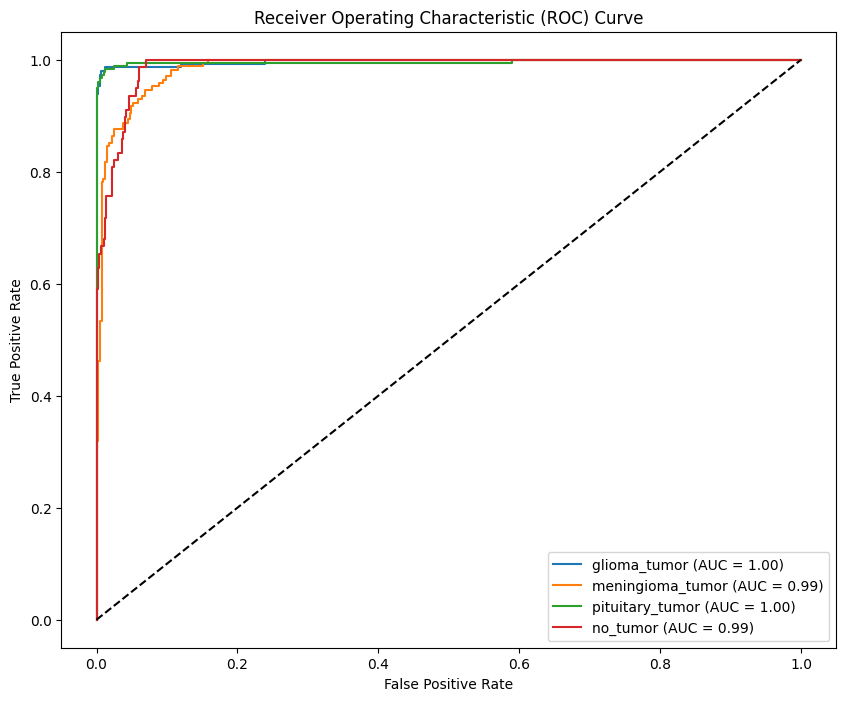

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
# Generating ROC CURVE
# Get predicted probabilities for each class
y_probs = svm_classifier.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(LABEL_MAP)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(LABEL_MAP)):
    plt.plot(fpr[i], tpr[i], label=f'{list(LABEL_MAP.keys())[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 13. Confusion Matrix
We visualize the confusion matrix.
Confusion matrix displays classification errors.

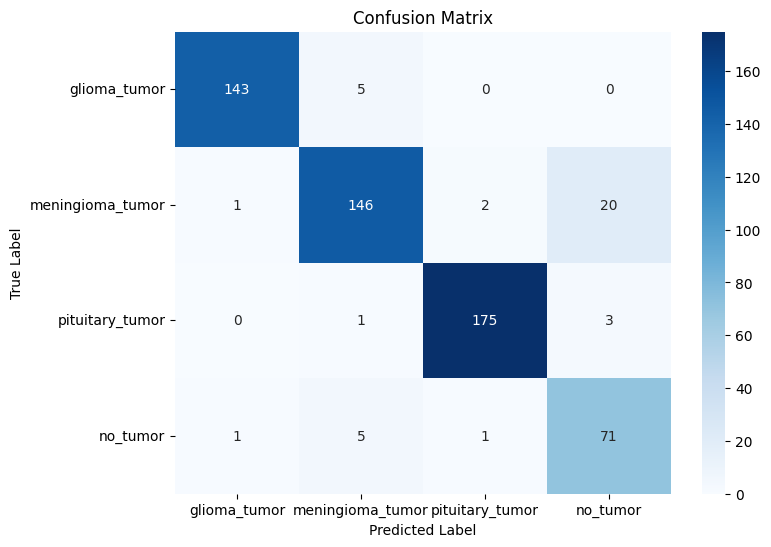

In [ ]:
# Generate and plot the confusion matrix
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 14. Save the Model and PCA Transformer
We save the trained SVM model, PCA transformer, and scaler for future use.

In [ ]:
# Save model and PCA transformer
joblib.dump(svm_classifier, "svm_model.pkl")
joblib.dump(pca, "pca_transform.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model, PCA, and Scaler saved successfully!")

Model, PCA, and Scaler saved successfully!


### 15. Function for Prediction on New Images
This function takes an image path and predicts the tumor type.

In [ ]:
# Function to predict tumor type
def predict_tumor(image_path):
    svm_classifier = joblib.load("svm_model.pkl")
    pca = joblib.load("pca_transform.pkl")
    scaler = joblib.load("scaler.pkl")

    img = load_img(image_path, target_size=IMG_SIZE, color_mode='grayscale')
    img_array = img_to_array(img).astype(np.uint8)
    img_array = cv2.equalizeHist(img_array)
    features = extract_features(img_array)

    img_scaled = scaler.transform([features])
    img_pca = pca.transform(img_scaled)
    prediction = svm_classifier.predict(img_pca)
    predicted_label = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(prediction[0])]

    return predicted_label

### 16. Test the Prediction Function
We test the model with a sample image.

In [ ]:
# Example usage
image_path = "/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(100).jpg"  # Change this to your test image path
predicted_tumor = predict_tumor(image_path)
print(f"Predicted Tumor Type: {predicted_tumor}")

Predicted Tumor Type: no_tumor


### Conclusion
This project successfully classifies brain tumors using SVM with feature extraction techniques (HOG & Sobel Edge Detection). PCA improves efficiency, and hyperparameter tuning enhances accuracy. The trained model is saved and can predict tumor types from new MRI scans.